In [1]:
import os
import datetime

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib.collections import PolyCollection
from matplotlib.patches import Polygon
from matplotlib import pyplot as plt

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Geographiclib - https://geographiclib.sourceforge.io/Python/2.0/
# conda install conda-forge::geographiclib
from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84

%matplotlib inline

In [2]:
plt.rcParams['font.size']      = 18
plt.rcParams['font.weight']    = 'bold'
plt.rcParams['axes.grid']      = True
plt.rcParams['axes.xmargin']   = 0
plt.rcParams['grid.linestyle'] = ':'

In [3]:
def plot_map(paths_df=None,figsize=(15,8)):
    ## World
    #xlim    = (-180,180)
    #ylim    = (-90,90)
    
    # Continental US (CONUS)
    xlim    = (-130,-56)
    ylim    = (20,55)
    
    ## CONUS + Canada
    #xlim    = (-130,-56)
    #ylim    = (20,80)
    
    fig     = plt.figure(figsize=figsize)
    ax      = fig.add_subplot(111,projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_title('')
    ax.gridlines(draw_labels=True)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    if paths_df is not None:
        fontdict = {'size':'large','weight':'bold'}
        offset   = 1.1
        cycle    = plt.rcParams['axes.prop_cycle']
        for inx,(rinx,row) in enumerate(paths_df.iterrows()):
            color = list(cycle)[inx%len(cycle)].get('color')
            # Plot Transmitter and Receiver locations
            pt_dcts = {}
            pt_dcts['tx'] = {'marker':'*','s':450}
            pt_dcts['rx'] = {'marker':'v','s':150}
            for pt_key,pt_dct in pt_dcts.items():
                lat        = row.get(pt_key+'_lat')
                lon        = row.get(pt_key+'_lon')
                lbl        = row.get(pt_key+'_lbl')

                if lat is None: continue
                    
                latLonStr  = '{:0.1f}\N{DEGREE SIGN}N, {:0.1f}\N{DEGREE SIGN}E'.format(lat,lon)
                if lbl is not None:
                    lbl_latLon = '{!s} ({!s})'.format(lbl,latLonStr)
                else:
                    lbl_latLon = '({!s})'.format(latLonStr)
                if lon > 180:
                    lon = lon - 360.
    
                ax.scatter(lon,lat,zorder=110,label=lbl_latLon,ec='k',fc=color,**pt_dct)
                if lbl is not None:
                    ax.text(lon,lat+offset,lbl,fontdict=fontdict,ha='center')
            # Plot the path
            if 'end_lat' in row.keys():
                end_key = 'end'
            elif 'rx_lat' in row.keys():
                end_key = 'rx'
            else:
                end_key = None

            if end_key is not None:
                tx_lat       = row.get('tx_lat')
                tx_lon       = row.get('tx_lon')
                
                end_lat      = row.get(end_key+'_lat')
                end_lon      = row.get(end_key+'_lon')
                end_lbl      = row.get(end_key+'_lbl')
                if end_lon > 180:
                    end_lon = end_lon - 360.

                lbl          = '{!s}-{!s}'.format(row['tx_lbl'],end_lbl)
                if end_key == 'end' and 'tx_rx_range_km' in row.keys():
                    rx_rng       = row.get('tx_rx_range_km')
                    end_rng      = row.get('tx_'+end_key+'_range_km')
                    end_azm      = row.get('tx_'+end_key+'_azm')
                    lbl_rngAzm   = '{!s} ({:.0f} km, {:.0f} km, {:.0f}\N{DEGREE SIGN} azm)'.format(lbl,rx_rng,end_rng,end_azm)
                else:
                    end_rng      = row.get('tx_'+end_key+'_range_km')
                    end_azm      = row.get('tx_'+end_key+'_azm')
                    lbl_rngAzm   = '{!s} ({:.0f} km, {:.0f}\N{DEGREE SIGN} azm)'.format(lbl,end_rng,end_azm)


                # Determine the ranges and azimuth along the profile path.
                invl    = geod.InverseLine(tx_lat,tx_lon,end_lat,end_lon)
                dist    = invl.s13*1e-3   # Distance in km
                az      = invl.azi1
                range_step = 1.

                ranges  = np.arange(0,dist,range_step)
        
                glats   = []
                glons   = []
                for x in ranges:
                    s   = min(x*1e3,invl.s13) # invl.s13 is the total line distance in m
                    tmp = invl.Position(s,Geodesic.STANDARD)
                    glat        = tmp['lat2']
                    glon        = tmp['lon2']
        
                    glats.append(glat)
                    glons.append(glon)

                ax.plot(glons,glats,label=lbl_rngAzm,lw=3,color=color,transform=ccrs.PlateCarree())
                
    # ax.legend(loc='lower right',fontsize='small')
    ax.legend(loc='lower right',prop={'size':'x-small','weight':'normal'},framealpha=1)
    
    plt.tight_layout()
    plt.show()

In [4]:
class Paths(object):
    def __init__(self,path_dcts):
        """
        Class for processing ray trace path transmitter, receiver, and end point locations.

        path_dcts: List of dictionaries specifying paths. Example:
            pdcts = []
            pdct = {}
            pdct['tx_lat']  =  30.
            pdct['tx_lon']  = -87.
            pdct['tx_lbl']  = 'TX 1'
            pdct['end_lat'] =  50.
            pdct['end_lon'] = -95.
            pdct['end_lbl'] = 'Path 1'
            pdcts.append(pdct)
        """
        self.df = pd.DataFrame(path_dcts)
        self.__add_endPoints__()
        self.__compute_rangeAzms__()
        
    def __compute_rangeAzms__(self):
        """
        Use geographic lib to calcuate the ranges [km] and azimuths [deg clockwise from North]
        of paths dataframe.
        """
        paths_df = self.df
        
        new_rows = []
        for rinx,row in paths_df.iterrows():
            tx_lat = row['tx_lat']
            tx_lon = row['tx_lon']
            endPts = ['rx','end']
            for endPt in endPts:
                end_lat = row.get(endPt+'_lat')
                end_lon = row.get(endPt+'_lon')
                if end_lat is not None:
                    # Determine the ranges and azimuth along the profile path.
                    invl    = geod.InverseLine(tx_lat,tx_lon,end_lat,end_lon)
                    dist    = invl.s13*1e-3   # Distance in km
                    azm     = invl.azi1
    
                    row['tx_{!s}_range_km'.format(endPt)] = dist
                    row['tx_{!s}_azm'.format(endPt)]      = azm
            new_rows.append(row)
    
        new_paths_df = pd.DataFrame(new_rows)
        self.df = new_paths_df

    def __add_endPoints__(self):
        """
        For each row in self.df, if a 'tx_end_range_km' is defined but 'end_lat' is not,
        compute and add an 'end_lat' and 'end_lon' from the tranmitter location
        in the direction of the receiver location for the distance 'tx_end_range_km'.
        """
        paths_df = self.df
        
        new_rows = []
        for rinx,row in paths_df.iterrows():
            if ('tx_end_range_km' in row.keys()) and ('rx_lat' in row.keys()) and ('end_lat' not in row.keys()):
                tx_lat = row['tx_lat']
                tx_lon = row['tx_lon']
                rx_lat = row['rx_lat']
                rx_lon = row['rx_lon']
                
                invl    = geod.InverseLine(tx_lat,tx_lon,rx_lat,rx_lon)
                rx_azm  = invl.azi1
                rng_m  = row['tx_end_range_km']*1e3

                tmp    = geod.Direct(tx_lat, tx_lon, rx_azm, rng_m)
                row['end_lat'] = tmp['lat2']
                row['end_lon'] = tmp['lon2']

                if (row.get('end_lbl') is None) and (row.get('rx_lbl') is not None):
                    row['end_lbl'] = row['rx_lbl']
                    
            new_rows.append(row)
        new_paths_df = pd.DataFrame(new_rows)
        
        self.df = new_paths_df
        

# 2023 Annular and 2024 Total Solar Eclipses

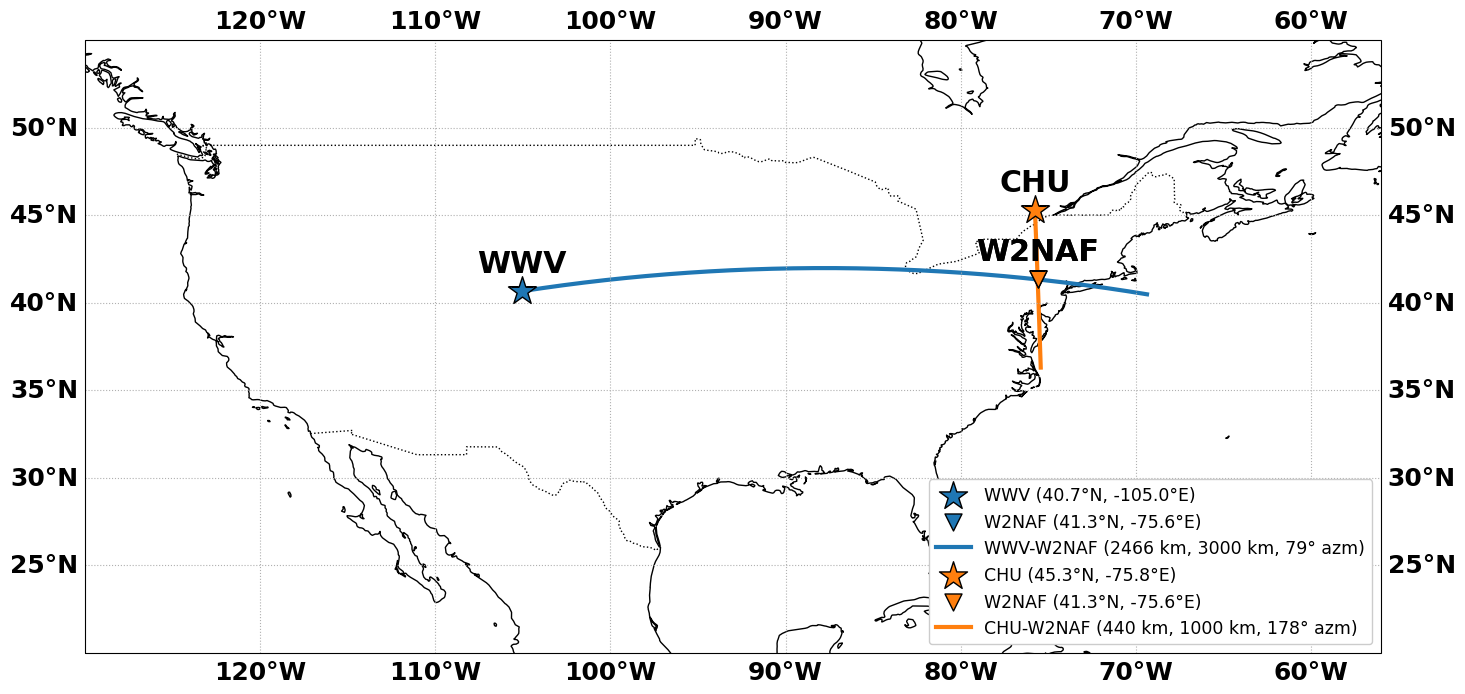

,tx_lbl,tx_lat,tx_lon,rx_lbl,rx_lat,rx_lon,tx_end_range_km,end_lat,end_lon,end_lbl,tx_rx_range_km,tx_rx_azm,tx_end_azm
0,WWV,40.668300,-105.038400,W2NAF,41.335116,-75.600692,3000.0,40.486491,-69.358614,W2NAF,2465.861950,78.545767,78.545767
1,CHU,45.294806,-75.757861,W2NAF,41.335116,-75.600692,1000.0,36.293382,-75.426174,W2NAF,440.101681,178.285607,178.285607


In [5]:
pdcts = []

pdct = {}
pdct['tx_lbl']  = 'WWV'
pdct['tx_lat']  =   40.6683
pdct['tx_lon']  = -105.0384
pdct['rx_lbl']  = 'W2NAF'
pdct['rx_lat']  =  41.335116
pdct['rx_lon']  = -75.600692
pdct['tx_end_range_km'] = 3000.

pdcts.append(pdct)

pdct = {}
pdct['tx_lbl']  = 'CHU'
pdct['tx_lat']  =   45.294806
pdct['tx_lon']  =  -75.757861
pdct['rx_lbl']  = 'W2NAF'
pdct['rx_lat']  =  41.335116
pdct['rx_lon']  = -75.600692
pdct['tx_end_range_km'] = 1000.

pdcts.append(pdct)

paths = Paths(pdcts)
plot_map(paths.df)
paths.df

# LSTID Event
## November 3, 2017
1. 1343 UTC
2. 1458 UTC
3. 1613 UTC
4. 1728 UTC

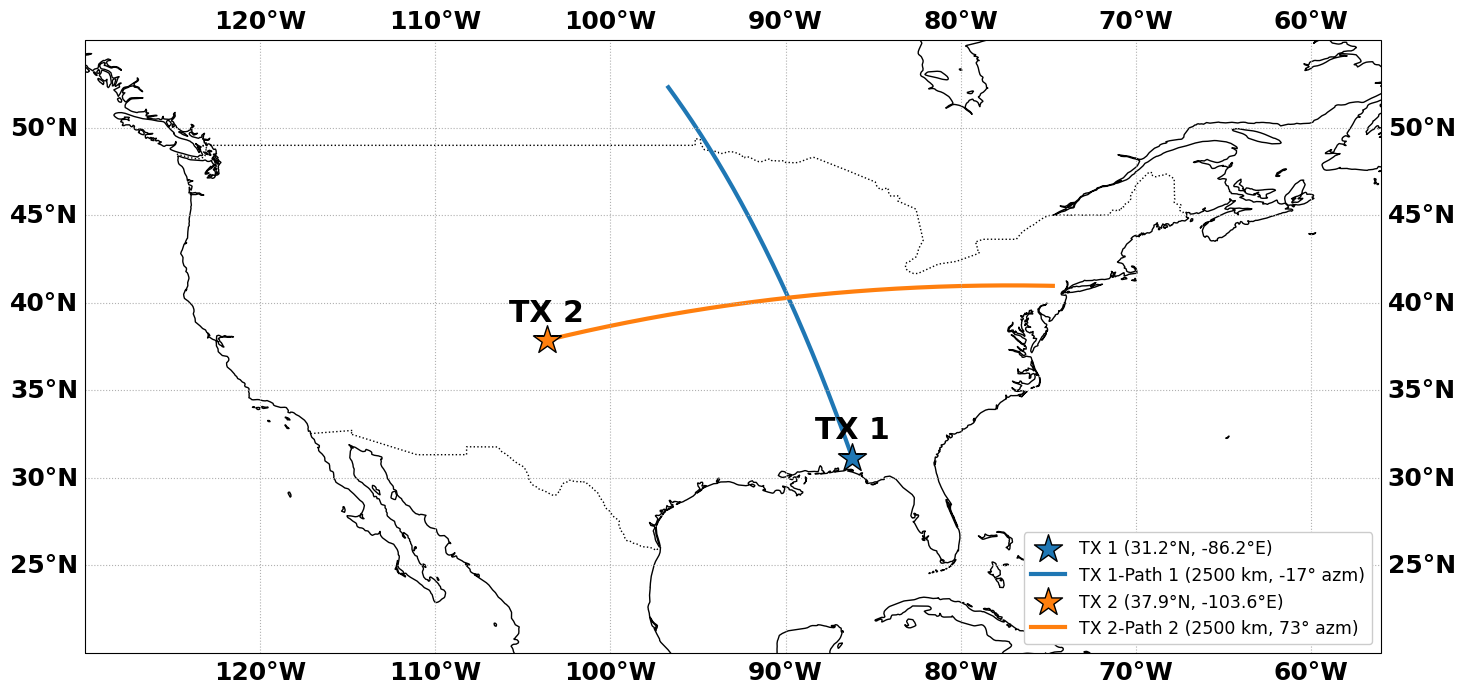

,tx_lat,tx_lon,tx_lbl,end_lat,end_lon,end_lbl,tx_end_range_km,tx_end_azm
0,31.159791,-86.188630,TX 1,52.307369,-96.691351,Path 1,2500.0,-17.0
1,37.870749,-103.627487,TX 2,40.969353,-74.735777,Path 2,2500.0,73.0


In [6]:
ctr_lat =  42.
ctr_lon = -90.
tid_azm = 163.
tx_end_range_rm = 2500.

pdcts = []

pdct = {}
tx_tmp  = geod.Direct(ctr_lat, ctr_lon, tid_azm, (tx_end_range_rm/2.)*1e3)
end_azm = tid_azm + 180.
if end_azm > 360:
    end_azm = end_azm - 360
end_tmp = geod.Direct(tx_tmp['lat2'], tx_tmp['lon2'], end_azm, tx_end_range_rm*1e3)
pdct['tx_lat']  = tx_tmp['lat2']
pdct['tx_lon']  = tx_tmp['lon2']
pdct['tx_lbl']  = 'TX 1'
pdct['end_lat'] = end_tmp['lat2']
pdct['end_lon'] = end_tmp['lon2']
pdct['end_lbl'] = 'Path 1'
pdcts.append(pdct)

pdct = {}
tid_azm = tid_azm +90.
tx_tmp  = geod.Direct(ctr_lat, ctr_lon, tid_azm, (tx_end_range_rm/2.)*1e3)
end_azm = tid_azm + 180.
if end_azm > 360:
    end_azm = end_azm - 360
end_tmp = geod.Direct(tx_tmp['lat2'], tx_tmp['lon2'], end_azm, tx_end_range_rm*1e3)
pdct['tx_lat']  = tx_tmp['lat2']
pdct['tx_lon']  = tx_tmp['lon2']
pdct['tx_lbl']  = 'TX 2'
pdct['end_lat'] = end_tmp['lat2']
pdct['end_lon'] = end_tmp['lon2']
pdct['end_lbl'] = 'Path 2'
pdcts.append(pdct)

paths = Paths(pdcts)
plot_map(paths.df)
paths.df